In [7]:
import pandas as pd

### importing data - training_variants and training_text

In [8]:
data = pd.read_csv('./train_data/training_variants')
print(f'number of data points, features: {data.shape}')
data.head()

number of data points, features: (3321, 4)


,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


In [9]:
text_data = pd.read_csv("./train_data/training_text", sep="\|\|", names=["ID","Text"], skiprows=1, engine='python')

In [10]:
print(f'shape: {text_data.shape}\n' )
text_data.head()

shape: (3321, 2)



,ID,Text
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


### pre-processing of text

In [11]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/sanved/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [12]:
stop_words = nltk.corpus.stopwords.words('english')

In [13]:
import re

_special_char_pattern = re.compile(r'[^a-zA-Z0-9\n]')
_multi_space_pattern = re.compile(r'\s+')

In [14]:
def nlp_preprocessing(total_text, index, column):
    if not isinstance(total_text, str):
        return

    # Remove special characters
    cleaned_text = _special_char_pattern.sub(' ', total_text)

    # whitespace (if more than 2, convert to 1
    cleaned_text = _multi_space_pattern.sub(' ', cleaned_text)

    # lowercase
    cleaned_text = cleaned_text.lower()

    # stop words
    words = [word for word in cleaned_text.split() if word not in stop_words]

    # processed text 
    text_data.at[index, column] = ' '.join(words)


In [15]:
import time

In [16]:
timestamp_start = time.time()
for idx, row in text_data.iterrows():
    if isinstance(row['Text'], str):
        nlp_preprocessing(row['Text'], idx, 'Text')
    else:
        print(f'no text data in row with id {idx}') 
timestamp_end = time.time()
print(f'time taken: {timestamp_end - timestamp_start} secs') 

no text data in row with id 1109
no text data in row with id 1277
no text data in row with id 1407
no text data in row with id 1639
no text data in row with id 2755
time taken: 142.81837391853333 secs


In [17]:
print(f'{text_data.shape}')
text_data.head()

(3321, 2)


,ID,Text
0,0,cyclin dependent kinases cdks regulate variety...
1,1,abstract background non small cell lung cancer...
2,2,abstract background non small cell lung cancer...
3,3,recent evidence demonstrated acquired uniparen...
4,4,oncogenic mutations monomeric casitas b lineag...


combining text data and variation data

In [18]:
res_data = pd.merge(data, text_data, on='ID', how='left')

In [19]:
print(f'shape: {res_data.shape}\n')
res_data.head()

shape: (3321, 5)



,ID,Gene,Variation,Class,Text
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


for those rows that do not have text data

In [20]:
missing_text_rows = res_data[res_data['Text'].isna() | (res_data['Text'].str.strip() == '')]
print(missing_text_rows)

        ID    Gene             Variation  Class Text
1109  1109   FANCA                S1088F      1  NaN
1277  1277  ARID5B  Truncating Mutations      1  NaN
1407  1407   FGFR3                 K508M      6  NaN
1639  1639    FLT1         Amplification      6  NaN
2755  2755    BRAF                 G596C      7  NaN


In [21]:
def fill_missing_text(row, reference_df):
    if pd.isna(row['Text']):
        # find matching row(s) with same Gene & Variation and non-null Text
        match = reference_df[
            (reference_df['Gene'] == row['Gene']) &
            (reference_df['Variation'] == row['Variation']) &
            (reference_df['Text'].notna())
        ]
        if not match.empty:
            return match.iloc[0]['Text']  
        else:
            print(f'found no exact match for row with id {row['ID']}')
    return row['Text']


In [22]:
res_data['Text'] = res_data.apply(lambda row: fill_missing_text(row, res_data), axis=1)

found no exact match for row with id 1109
found no exact match for row with id 1277
found no exact match for row with id 1407
found no exact match for row with id 1639
found no exact match for row with id 2755


In [23]:
missing_text_rows = res_data[res_data['Text'].isna() | (res_data['Text'].str.strip() == '')]
print(missing_text_rows)

        ID    Gene             Variation  Class Text
1109  1109   FANCA                S1088F      1  NaN
1277  1277  ARID5B  Truncating Mutations      1  NaN
1407  1407   FGFR3                 K508M      6  NaN
1639  1639    FLT1         Amplification      6  NaN
2755  2755    BRAF                 G596C      7  NaN


can't find the exact matches so we'll just use the gene name + variation name

In [24]:
# loc(row, col)
res_data.loc[res_data['Text'].isnull(), 'Text'] = (
    res_data.loc[res_data['Text'].isnull(), 'Gene'].astype(str) + ' ' +
    res_data.loc[res_data['Text'].isnull(), 'Variation'].astype(str)
)

In [25]:
missing_text_rows = res_data[res_data['Text'].isna() | (res_data['Text'].str.strip() == '')]
print(missing_text_rows)

Empty DataFrame
Columns: [ID, Gene, Variation, Class, Text]
Index: []


### splitting the data

In [26]:
y_true = res_data['Class'].values
print(f'labels: {y_true}')

labels: [1 2 2 ... 1 4 4]


In [27]:
res_data['Gene'] = res_data['Gene'].str.replace('\s+', '_', regex=True)
res_data['Variation'] = res_data['Variation'].str.replace('\s+', '_', regex=True)

In [28]:
res_data.head()

,ID,Gene,Variation,Class,Text
0,0,FAM58A,Truncating_Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


replaced spaces with underscores

In [29]:
from sklearn.model_selection import train_test_split

In [30]:
X_train_full, X_test, y_train_full, y_test = train_test_split(
    res_data, y_true, stratify=y_true, test_size=0.2, random_state=42
)

In [31]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, stratify=y_train_full, test_size=0.2, random_state=42
)

- (X_train, y_train) is the training set 
- (X_val, y_val) is CV set
- (X_test, y_test) is test set

In [32]:
print(f'train data: {X_train.shape}')
print(f'train data: {X_val.shape}')
print(f'train data: {X_test.shape}')

train data: (2124, 5)
train data: (532, 5)
train data: (665, 5)


### plotting class distributions 

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

In [34]:
def plot_class_distribution(y, title):
    plt.figure(figsize=(3,3))
    sns.countplot(x=y, hue=y, palette='crest', linewidth=0.7, legend=False)
    plt.title(title, fontsize=12)
    plt.xlabel('')
    plt.ylabel('Count', fontsize=10)
    plt.xticks(fontsize=9)
    plt.yticks(fontsize=9)
    plt.tight_layout()
    plt.show()

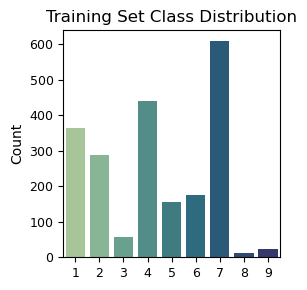

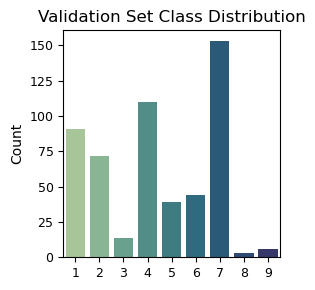

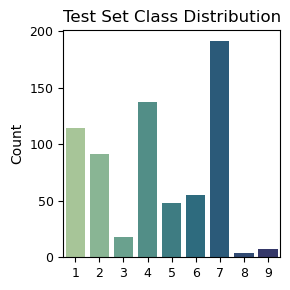

In [35]:
plot_class_distribution(y_train, 'Training Set Class Distribution')
print()
plot_class_distribution(y_val, 'Validation Set Class Distribution')
print()
plot_class_distribution(y_test, 'Test Set Class Distribution')

### analysis of gene

Here, gene is a categorical random variable. 

In [36]:
X_train['Gene'].value_counts()

Gene
BRCA1    154
TP53     104
EGFR      89
PTEN      88
BRCA2     83
        ... 
RARA       1
FGF4       1
FGFR4      1
NSD1       1
MEN1       1
Name: count, Length: 236, dtype: int64

The distribution is skewed. The top ones occur a lot of times. 

#### Featurizing Gene using response coding

`Gene` takes many values. One-hot encoding would be inefficient. <br>
`Class` is categorical. <br>
If it were ordinal or binary, we'd have used Mean target class (Encoded value for gene G =  Mean(Class) for rows with Gene G. <br>
But it is multiclass. We'll use probability per class. 

We'll make one column per class. <br>
| Gene | P(Class=1) | P(Class=2) | ... |
| ---- | ---------- | ---------- | --- |
| CBL  | 0.1        | 0.4        | ... |


For each unique `Gene`, we'll calculate: 
$$
P(Class=c_i∣Gene=g)
$$
So for each `Gene`, we'll get a vector of probabilities: 
| Gene   | P(Class=1) | P(Class=2) | P(Class=3) |
| ------ | ---------- | ---------- | ---------- |
| CBL    | 0.1        | 0.6        | 0.3        |
| FAM58A | 1.0        | 0.0        | 0.0        |


The distribution is a long-tailed distribution. 
We could overfit using naive class probability encoding. 
We'll just use smoothing. 
$$
\text{Smoothed Probability} = \frac{ n_i \cdot p_i + \alpha \cdot p_{global} }{ n_i + \alpha }
$$
$n_i$ = # of samples for that gene
$p_i$ = empirical probability for that gene
$p_{global}$ = overall class probability
$\alpha$ = smoothing factor

In [40]:
import numpy as np

In [41]:
def build_smoothed_prob_dict(df, feature_col, target_col='Class', alpha=1):
    '''
    for each value in feature_col, we'll build a vector of smoothed probabilities

    feature_col = 'Gene', target_col = 'Class' 
    higher the alpha (smoothing factor), more the global influence

    returns a dict mapping feature value to a 9-dim vector (probabilities corresp to each class)
    '''

    # calc global class probabilities 
    global_class_counts = df[target_col].value_counts().sort_index()
    global_class_probs = global_class_counts / global_class_counts.sum()
    global_class_probs = global_class_probs.to_numpy()

    prob_dict = {}

    # process each unique val in feature
    for value in df[feature_col].unique():
        subset = df[df[feature_col] == value]
        count = len(subset)

        # get empirical class distribution for this feature value 
        value_class_counts = subset[target_col].value_counts().sort_index()
        value_class_probs = np.zeros(9)

        for cls in range(1, 10):
            value_class_probs[cls-1] = value_class_counts.get(cls, 0)

        value_class_probs = value_class_probs / count if count > 0 else np.zeros(9)

        smoothed = (count * value_class_probs + alpha * global_class_probs) / (count + alpha)
        prob_dict[value] = smoothed

    return prob_dict

In [42]:
def encode_feature_with_prob_vectors(df, feature_col, prob_dict):
    # encode a categorical column 

    encoded = []

    for val in df[feature_col]:
        if val in prob_dict:
            encoded.append(prob_dict[val])
        else:
            encoded.append(np.ones(9)/9)    # for unseen ones

    return np.array(encoded)

In [44]:
alpha = 1

gene_prob_dict = build_smoothed_prob_dict(X_train, feature_col='Gene', target_col='Class', alpha=alpha)
print(gene_prob_dict)

{'ETV6': array([0.14636299, 0.142008  , 0.00335452, 0.40083569, 0.00912194,
       0.01035782, 0.2858404 , 0.00070621, 0.00141243]), 'RUNX1': array([1.86523762e-01, 8.00376648e-03, 1.57859754e-03, 6.59216794e-01,
       4.29267752e-03, 6.36977955e-02, 7.56895979e-02, 3.32336324e-04,
       6.64672649e-04]), 'TP53': array([5.34960990e-01, 1.08196574e-02, 1.93032015e-02, 3.54349386e-01,
       1.97426240e-02, 4.84082145e-02, 2.73069680e-03, 5.38068335e-05,
       9.63142319e-03]), 'ALK': array([3.88418079e-03, 7.12741825e-02, 1.14246276e-01, 4.69739771e-03,
       6.98403527e-02, 1.88323917e-03, 7.33789163e-01, 1.28402671e-04,
       2.56805342e-04]), 'AR': array([1.27700233e-01, 8.00376648e-03, 1.57859754e-03, 1.21579705e-02,
       1.80763266e-01, 1.81344854e-01, 4.87454304e-01, 3.32336324e-04,
       6.64672649e-04]), 'BRCA2': array([1.44891714e-01, 1.61980988e-03, 3.19478074e-04, 2.62700655e-02,
       1.55630661e-01, 6.67653125e-01, 3.41337100e-03, 6.72585418e-05,
       1.34517084e

In [48]:
train_gene_feature_responseCoding = encode_feature_with_prob_vectors(X_train, 'Gene', gene_prob_dict)

In [47]:
test_gene_feature_responseCoding = encode_feature_with_prob_vectors(X_test, 'Gene', gene_prob_dict)
cv_gene_feature_responseCoding = encode_feature_with_prob_vectors(X_val, 'Gene', gene_prob_dict)

In [52]:
train_gene_feature_responseCoding.shape

(2124, 9)

#### using one-hot encoding this time